# Application: new experiment

This notebook allows users to find generic genes in their experiment of interest using an existing VAE model

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [42]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import process, new_experiment_process, calc

## User input

User needs to define the following:

1. Template experiment. This is the experiment you are interested in studying
2. Training compendium used to train VAE, including unnormalized gene mapped version and normalized version
3. Scaler transform used to normalize the training compendium
4. Directory containing trained VAE model
5. Experiment id to use to label newly create simulated experiments

## TO DO:
#If want to train a new model then need to have gene expression data of what form, gene ids of what form? Instructions???

In [31]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_new_experiment.tsv")
)

params = utils.read_config(config_filename)

In [32]:
# Load params

# Local directory to store intermediate files
local_dir = params['local_dir']

# Number of simulated experiments to generate
num_runs = params['num_simulated']

# Directory containing trained VAE model
vae_model_dir = params['vae_model_dir']

# Dimension of latent space used in VAE model
latent_dim = params['latent_dim']

# ID for template experiment
# This ID will be used to label new simulated experiments
project_id = params['project_id']

# Template experiment filename
template_filename = params['raw_template_filename']
processed_template_filename = params['processed_template_filename']

# Training dataset used for existing VAE model
mapped_compendium_filename = params['mapped_compendium_filename']

# Normalized compendium filename
normalized_compendium_filename = params['normalized_compendium_filename']

# Scaler transform used to scale compendium data into 0-1 range for training
scaler_filename = params['scaler_filename']

# Test statistic used to rank genes by
col_to_rank_genes = params['rank_genes_by']

SyntaxError: EOL while scanning string literal (<ipython-input-32-28acde964608>, line 56)

In [52]:
# Output filename
gene_summary_filename = f"generic_gene_summary_{project_id}.tsv"

## Process

In [ ]:
# Template experiment needs to be of the form sample x gene
transposed_template_filename = "/home/alexandra/Documents/Data/Generic_expression_patterns/Costello_BladderCancer_ResistantCells_Counts_12-8-20_transposed.txt"

new_experiment_process.transpose_save(template_filename, transposed_template_filename)

In [5]:
# Check that the feature space matches between template experiment and VAE model.  
# (i.e. ensure genes in template and VAE model are the same).
mapped_template_experiment = new_experiment_process.compare_match_features(
    transposed_template_filename,
    normalized_compendium_filename
)

'mapped_template_experiment = new_experiment_process.compare_match_features(\n    transposed_template_filename,\n    normalized_compendium_filename\n)'

In [6]:
# Scale template experiment to be within the same range as the
# normalized training dataset used for the VAE model
new_experiment_process.normalize_template_experiment(
    mapped_template_experiment,
    scaler_filename
)

'processed_template_experiment = new_experiment_process.normalize_template_experiment(\n    mapped_template_experiment,\n    scaler_filename\n)    '

## Simulate experiments based on template experiment

Embed template experiment into learned latent space and linearly shift template experiment to different locations of the latent space to create new experiments

In [7]:
# Simulate experiments based on template experiment
# Embed template experiment into learned latent space
# Linearly shift template experiment to different locations of the latent space

normalized_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
processed_template_data = pd.read_csv(processed_template_filename, sep="\t", index_col=0, header=0)
for run_id in range(num_runs):
    new_experiment_process.embed_shift_template_experiment(
        normalized_data,
        processed_template_experiment,
        vae_model_dir,
        project_id,
        scaler_filename,
        local_dir,
        latent_dim,
        run_id
    )

'for run_id in range(num_runs):\n    new_experiment_process.embed_shift_template_experiment(\n        normalized_data,\n        processed_template_experiment,\n        vae_model_dir,\n        project_id,\n        scaler_filename,\n        local_dir,\n        latent_dim,\n        run_id\n    )'

## Differential expression analysis

* If data is RNA-seq then use DESeq2
* If data is microarray then use Limma

NOTE: Eventually provide the ability to use other methods

In [8]:
# Modify template and simulated experiments based on comparison

if os.path.exists(sample_id_metadata_filename):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_filename, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    # Modify simulated experiments
    process.subset_samples(
        sample_ids_to_drop,
        num_runs,
        local_dir,
        project_id
    )
    
# Modify template experiment
process.subset_samples_template(
    processed_template_filename,
    sample_ids_to_drop,
)

'# Modify template and simulated experiments based on comparison\nif os.path.exists(sample_id_metadata_filename):\n    # Read in metadata\n    metadata = pd.read_csv(sample_id_metadata_filename, sep=\'\t\', header=0, index_col=0)\n    \n    # Get samples to be dropped\n    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)\n\n    process.subset_samples(\n        sample_ids_to_drop,\n        num_runs,\n        local_dir,\n        project_id\n    )\n    \n# Modify template experiment\nprocess.subset_samples_template(\n    processed_template_filename,\n    sample_ids_to_drop,\n)'

In [10]:
# Round simulated and template read counts to int in order to run DESeq.
# This step modifies the following files again:
# "<local_dir>/pseudo_experiments/selected_simulated_data_SRP012656_<n>.txt"
process.recast_int(num_runs, local_dir, project_id)
process.recast_int_template(processed_template_filename)

In [11]:
# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    local_dir,
    f"{project_id}_groups.tsv"
)

In [12]:
# Check whether ordering of sample ids is consistent between gene expression data and metadata
process.compare_and_reorder_samples(processed_template_filename, metadata_filename)

sample ids are ordered correctly


In [13]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [14]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_SRP012656_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id, 
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE


In [15]:
# Check whether ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
        
    process.compare_and_reorder_samples(simulated_data_filename, metadata_filename)

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


In [16]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir, 
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    get_DE_stats_DESeq(metadata_filename,
                       project_id, 
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checki

In [47]:
# Quick validation
def make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
):
    
    # Read template DE stats
    template_DE_stats_df = pd.read_csv(
        template_DE_stats_filename,
        sep="\t",
        index_col=0,
        header=0
    )
    
    # Take -log10 of adjusted p-value
    template_DE_stats_df["padj_log10"] = -np.log10(template_DE_stats_df["padj"])

    # Label DEGs by traditional criteria
    # log2FC > 1
    # padj < 0.05
    template_DE_stats_df["gene group"] = "none"
    template_DE_stats_df.loc[(abs(template_DE_stats_df["log2FoldChange"])>1) &
                          (template_DE_stats_df["padj"] <0.05),
                              "gene group"
                         ] = "DEG"

    # Plot
    colors = ["lightgrey", "#2c7fb8"]

    f = sns.scatterplot(
       data=template_DE_stats_df,
        x="log2FoldChange",
        y="padj_log10",
        hue="gene group",
        hue_order=["none", "DEG"],
        style="gene group",
        markers={
            "none": ".",
            "DEG": "o",
        },
        palette=colors,
        linewidth=0,
        alpha=0.5,
        )
    
    f.set_xlabel("log2 Fold Change", fontsize=14, fontname="Verdana")
    f.set_ylabel("-log10(FDR adjusted p-value)", fontsize=14, fontname="Verdana")
    f.set_title(f"Template experiment ({project_id})", fontsize=16, fontname="Verdana")
    
def make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    num_examples
):
    fig, axes = plt.subplots(ncols=num_examples, nrows=1, figsize=(15, 4))
    
    for i in range(num_examples):
        
        # Get filename
        simulated_DE_stats_filename = os.path.join(
            simulated_DE_stats_dir,
            f"DE_stats_simulated_data_{project_id}_{i}.txt"
        )
        
        # Read simulated DE stats
        simulated_DE_stats_df = pd.read_csv(
            simulated_DE_stats_filename,
            sep="\t",
            index_col=0,
            header=0
        )

        # Take -log10 of adjusted p-value
        simulated_DE_stats_df["padj_log10"] = -np.log10(simulated_DE_stats_df["padj"])

        # Label DEGs by traditional criteria
        # log2FC > 1
        # padj < 0.05
        simulated_DE_stats_df["gene group"] = "none"
        simulated_DE_stats_df.loc[(abs(simulated_DE_stats_df["log2FoldChange"])>1) &
                              (simulated_DE_stats_df["padj"] <0.05),
                                  "gene group"
                             ] = "DEG"
        
        # Plot
        colors = ["lightgrey", "#2c7fb8"]
        
        f = sns.scatterplot(
           data=simulated_DE_stats_df,
            x="log2FoldChange",
            y="padj_log10",
            hue="gene group",
            hue_order=["none", "DEG"],
            style="gene group",
            markers={
                "none": ".",
                "DEG": "o",
            },
            palette=colors,
            linewidth=0,
            alpha=0.5,
            legend=False,
            ax=axes[i],
            )
        
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        
        
    fig.legend(labels=["DEGs", "other genes"], loc='center right')
    fig.text(0.5, 0.0, "log2 Fold Change",ha="center", fontsize=14, fontname="Verdana")
    fig.text(0.08, 0.5, "-log10(FDR adjusted p-value)", va="center", rotation="vertical", fontsize=14, fontname="Verdana")
    fig.suptitle(f"Example simulated experiments based on {project_id}", fontsize=16, fontname="Verdana")

In [44]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats['padj']<0.01) & (abs(template_DE_stats['log2FoldChange'])>1)]
print(selected.shape)

(2184, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


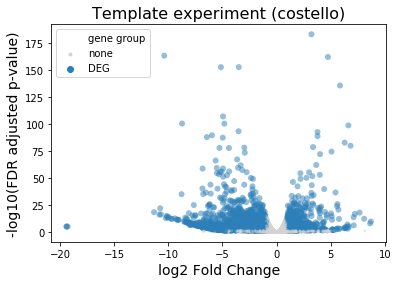

In [45]:
make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
)

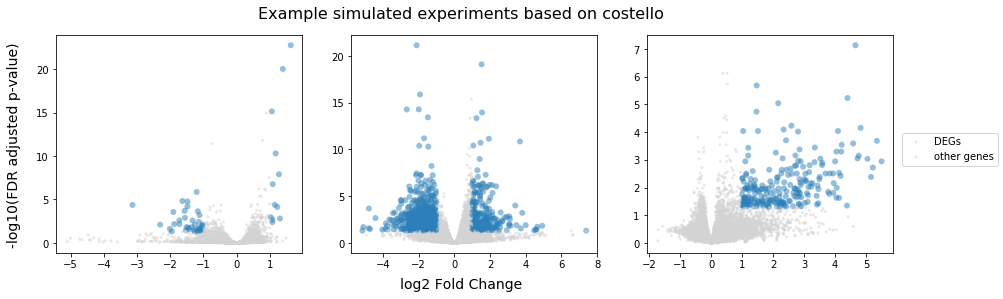

In [51]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")
num_examples = 3
make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    num_examples
)

## Rank genes

Add description

In [17]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id, 'DE')

print(simulated_DE_stats_all.shape)

(443850, 7)


In [18]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [23]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(
    col_to_rank_genes,
    simulated_DE_stats_all,
    'DE'
)

In [26]:
# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,      
    template_DE_stats,
    True
)

In [27]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,
    simulated_DE_summary_stats,
    False
)

## Summary table

Description of table columns

In [35]:
# Get summary table
# Description of table columns here
summary_gene_ranks = process.generate_summary_table(
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    'gene',
    params
)

summary_gene_ranks.sort_values(by="abs(Z score)", ascending=False).head(10)

(17272, 13)


,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),abs(Z score)
NDN,NDN,6.396788e-17,33279.0,10.680464,0.890896,3537.0,0.218340,0.191885,25,54.522808
IDI2,IDI2,5.292786e-19,33282.0,11.316627,0.841315,2823.0,0.251023,0.219566,25,50.397722
PARD3B,PARD3B,1.477131e-08,33237.0,7.915926,0.695817,8479.0,0.287445,0.185007,25,41.233417
LYPD1,LYPD1,7.960649e-14,33274.0,10.006575,0.742840,9802.0,0.384826,0.264701,25,36.349570
MMEL1,MMEL1,5.256213e-04,33071.0,5.604744,0.841222,3940.0,0.210825,0.149180,25,36.157163
PGAP2,PGAP2,3.351643e-93,32559.0,3.784368,0.844693,3479.0,0.166350,0.109643,25,32.998084
CPQ,CPQ,1.719937e-05,33032.0,5.353757,0.590735,4175.0,0.241272,0.157120,25,32.538799
LDOC1,LDOC1,1.581709e-80,33195.0,6.835554,0.779615,4889.0,0.256177,0.202880,25,32.429817
GLB1L2,GLB1L2,2.916661e-15,33162.0,6.519270,0.765301,4516.0,0.236036,0.203922,25,30.811897
NCKAP5,NCKAP5,2.932335e-13,33270.0,9.400262,0.724656,5254.0,0.321348,0.294744,25,30.802697


In [54]:
# Take a look at which genes were generic based on ranking
summary_gene_ranks.sort_values(by="Rank (simulated)", ascending=False).head(10)

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),abs(Z score)
TG,TG,0.594419,19844.0,0.871353,0.306680,17754.0,4.793059,4.318455,17,0.908127
GH2,GH2,NaN,28938.0,1.805032,0.115688,17753.0,4.596278,5.419644,15,0.515024
CLTA,CLTA,0.048872,12484.0,0.407473,0.095788,17752.0,3.624475,2.310864,23,1.392121
IL17F,IL17F,NaN,NaN,NaN,0.160618,17751.0,3.546706,2.250578,14,NaN
MUC7,MUC7,NaN,NaN,NaN,0.337879,17750.0,3.649744,2.209733,16,NaN
FABP4,FABP4,0.001291,29619.0,1.959607,0.291820,17749.0,3.225400,2.301231,24,0.550051
HTN3,HTN3,NaN,28669.0,1.778492,0.443349,17748.0,3.351321,1.999535,12,0.786598
SCNN1D,SCNN1D,0.732037,12550.0,0.410594,0.512198,17747.0,3.122795,1.707688,16,1.588230
PRM1,PRM1,NaN,NaN,NaN,0.633369,17746.0,3.654433,4.514825,18,NaN
DEFB119,DEFB119,NaN,NaN,NaN,0.637537,17745.0,2.813722,1.624017,15,NaN


In [53]:
# Save
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')